In [1]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install -q git+https://github.com/carlosluis/stable-baselines3@fix_tests

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  freeglut3 freeglut3-dev xvfb
0 upgraded, 3 newly installed, 0 to remove and 5 not upgraded.
Need to get 982 kB of archives.
After this operation, 3,350 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freeglut3-dev amd64 2.8.1-3 [124 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.11 [785 kB]
Fetched 982 kB in 2s (411 kB/s)
Selecting previously unselected package freeglut3:amd64.
(Reading database ... 123991 files and directories currently installed.)
Pr

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

import itertools
import random

%load_ext autoreload
%autoreload 2

In [3]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Simple toy MDP

In [4]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

env = gym.make("CartPole-v1")
expert = PPO(
    policy=MlpPolicy,
    env=env,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
)

In [5]:
from stable_baselines3.common.evaluation import evaluate_policy

In [6]:
# Use a separate environement for evaluation
eval_env = gym.make('CartPole-v1')

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(expert, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:71: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean_reward:389.31 +/- 182.28


In [7]:
expert.learn(10_000)  # Note: set to 10000 to train a proficient expert

In [8]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(expert, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:500.00 +/- 0.00


In [9]:
def generate_expert_trajectories(expert, env, num_trajectories=100, max_length=20, deterministic=True):
    trajectories = []
    for i in range(num_trajectories):
        episode = []
        obs, _ = env.reset()
        for _ in range(max_length):
            action, _states = expert.predict(obs, deterministic=deterministic)

            next_obs, reward, terminate, truncate, info = env.step(action)
            done = (terminate or truncate)
            episode.append({'cur_state': obs, 'action': action, 'next_state': next_obs, 'reward': reward, 'done': done})
            obs = next_obs
                        
            if done:
                break
        trajectories.append(episode)
    return trajectories

In [121]:
# trajs = generate_expert_trajectories(expert, env, num_trajectories=500, max_length=200)
trajs = generate_expert_trajectories(expert, env, num_trajectories=500, max_length=200, deterministic=False)

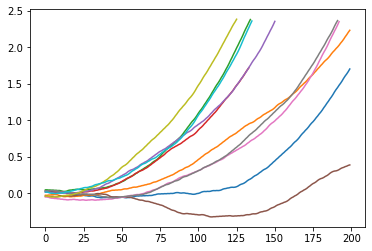

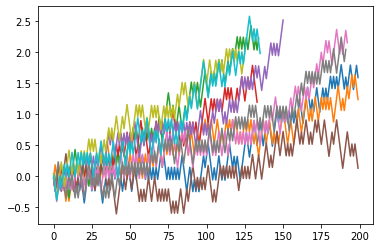

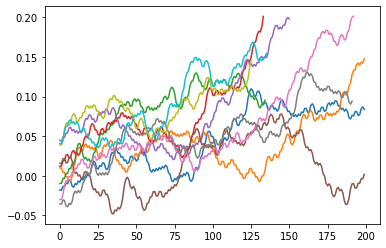

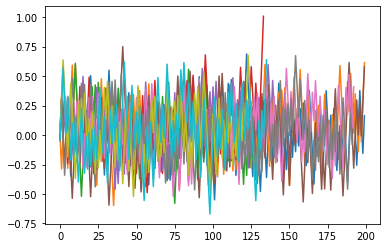

In [122]:
# Sanity check. Trajectories are different
for i in range(10):
    plt.plot([x['cur_state'][0] for x in trajs[i]])
plt.show()

for i in range(10):
    plt.plot([x['cur_state'][1] for x in trajs[i]])
plt.show()

for i in range(10):
    plt.plot([x['cur_state'][2] for x in trajs[i]])
plt.show()

for i in range(10):
    plt.plot([x['cur_state'][3] for x in trajs[i]])
plt.show()


# Score-matching approach 

In [125]:
class MlpReward(nn.Module):
    def __init__(self, input_dim, hiddens=[32, 64]):
        super().__init__()
        self.input_dim = input_dim

        prev_dim = self.input_dim
        layers = []
        for i, next_dim in enumerate(hiddens):
            layers.append(nn.Linear(prev_dim, next_dim))
            layers.append(nn.Softplus())
            prev_dim = next_dim
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        self.module = nn.Sequential(*layers)

        # self.module = nn.Linear(self.input_dim, 1, bias=False)

    def forward(self, x):
        return self.module(x)

In [232]:
def score_matching_loss(trajs, reward_fn):
    loss = 0
    cur_states = []
    for trajectory in trajs:
        for step in trajectory:
            cur_states.append(torch.from_numpy(step['cur_state']).unsqueeze(0))

    cur_state = torch.cat(cur_states, dim=0)
    cur_state.requires_grad = True
    v = torch.randn_like(cur_state)

    reward = reward_fn(cur_state)

    # First term
    grad_state = torch.autograd.grad(reward.sum(), inputs=cur_state, create_graph=True)[0]
    loss_term_1 = (v * grad_state).sum(dim=-1).pow(2).mean()
    # loss_term_1 = (grad_state).pow(2).sum(dim=-1).mean()
    
    # Second term
    vector_hessian_prod = torch.autograd.functional.hvp(func=lambda x: reward_fn(x).sum(), inputs=cur_state, v=v, create_graph=True)[-1]
    loss_term_2 = (v * vector_hessian_prod).sum(dim=-1).mean()

    loss = loss_term_1 + loss_term_2 * 2    
    return loss

In [236]:
my_reward = MlpReward(env.observation_space.shape[0], hiddens=[32, 32, 32])

optimizer = torch.optim.Adam(
    my_reward.parameters(),
    lr=1e-3, betas=(0.9, 0.99)
)

In [237]:
epochs = 100
batch_size = 32


-0.03232590854167938


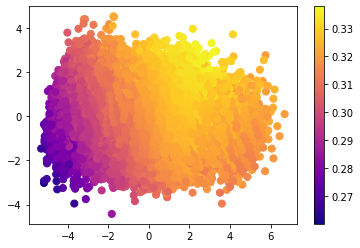

-110.80648040771484


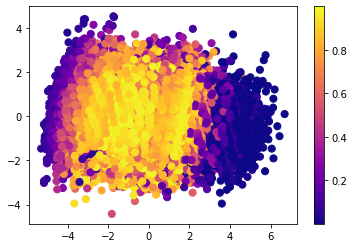

-293.0673828125


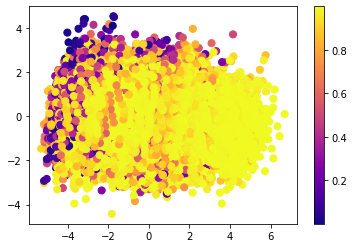

-514.673095703125


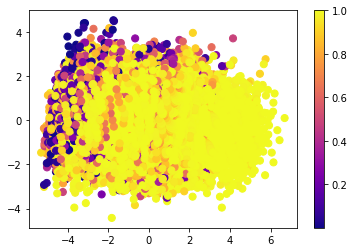

-529.2391357421875


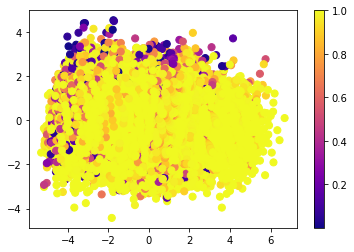

In [238]:
done = False
for epoch in range(epochs):
    random.shuffle(trajs)
    for i in range(0, len(trajs), batch_size):
        batch = trajs[i : min(i + batch_size, len(trajs))]

        optimizer.zero_grad()
        loss = score_matching_loss(batch, my_reward)
        loss.backward()
        optimizer.step()


In [217]:
my_reward(torch.ones((1, 4)))

tensor([[6.3702e-12]], grad_fn=<SigmoidBackward0>)

## Visualizing the learned reward

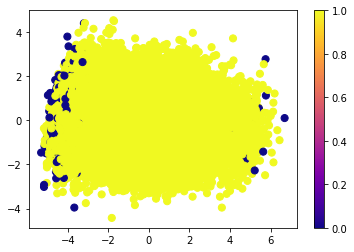

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

all_states = [trajs[i][j]['cur_state'].tolist() for i in range(len(trajs))  for j in range(len(trajs[i]))]
all_rewards = [0 if trajs[i][j]['done'] else 1 for i in range(len(trajs))  for j in range(len(trajs[i]))]

x = StandardScaler().fit_transform(np.array(all_states))
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x)
x_2d.shape

f, ax = plt.subplots()
points = ax.scatter(x_2d[:, 0], x_2d[:,1], c=all_rewards, s=50, cmap="plasma")
f.colorbar(points)


plt.show()

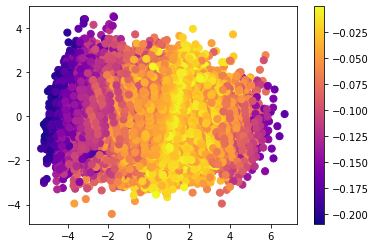

In [124]:
angles = (-abs(np.array(all_states)[:,2])).tolist()
f, ax = plt.subplots()
points = ax.scatter(x_2d[:, 0], x_2d[:,1], c=angles, s=50, cmap="plasma")
f.colorbar(points)

plt.show()

In [239]:
pred_rewards_all = my_reward(torch.tensor(all_states))
print(torch.min(pred_rewards_all),torch.max(pred_rewards_all))

tensor(4.3367e-06, grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


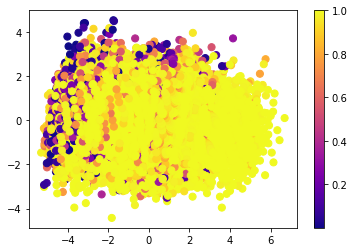

In [240]:
pra = pred_rewards_all.clone().detach().cpu().numpy()[:,0].tolist()
f, ax = plt.subplots()
points = ax.scatter(x_2d[:, 0], x_2d[:,1], c=pra, s=50, cmap="plasma")
f.colorbar(points)

plt.show()

## Training a policy with the learned reward

In [241]:

class MyEnv(gym.envs.classic_control.CartPoleEnv):
    def __init__(self, *args, **kwargs):
        my_reward = kwargs.pop('my_reward')
        super().__init__(*args, **kwargs)
        self.my_reward = my_reward
    
    def step(self, action):
        next_obs, reward, terminate, truncate, info = super().step(action)
        reward = self.my_reward(torch.from_numpy(next_obs).unsqueeze(0)).clone().detach().cpu().numpy().item()
        return next_obs, reward, terminate, truncate, info

In [242]:
custom_reward_env = MyEnv(my_reward=my_reward)
expert = PPO(
    policy=MlpPolicy,
    env=custom_reward_env,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
)

In [67]:
#@title
# The agent at initialization
mean_reward, std_reward = evaluate_policy(expert, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:71: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean_reward:368.39 +/- 192.05


In [243]:
expert.learn(20_000)

In [244]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(expert, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:71: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean_reward:490.91 +/- 26.83


In [245]:
def save_trajectory(model, env):
    # This function will only work for a single Environment
    done = False
    obs = env.reset()[0]
    images = [env.render()]
    while not done:
        # _states are only useful when using LSTM policies
        action, _states = model.predict(obs, deterministic=True)
        # here, action, rewards and dones are arrays
        # because we are using vectorized env
        obs, reward, done_ter, done_trun, info = env.step(action)
        done = (done_ter or done_trun)
        images.append(env.render())

    return images

In [226]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 92 kB/s 


In [246]:
images = save_trajectory(expert, gym.make('CartPole-v1', render_mode="rgb_array"))

In [250]:
! rm -rf ./images/*.jpeg

In [251]:
from PIL import Image
for i, image in enumerate(images):
    im = Image.fromarray(image)
    im.save(f"images/{i:05d}.jpeg")

In [252]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [253]:
!ffmpeg -r 15 -i ./images/%05d.jpeg -vcodec mpeg4 -y -an  gif.mp4

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [ ]:
!rm ./images/*.jpeg

# Behavioral Cloning